## Loading images and labels (training data only) and save in tfrec format

- makes it easier to get onto google colab and for reasons outlined below.

- mainly based on : https://github.com/rom1504/image_embeddings and https://towardsdatascience.com/a-practical-guide-to-tfrecords-584536bc786c

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

%matplotlib inline

import tensorflow as tf

import tqdm # progress bar

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

base_path = '../data/train/'
str_list = ['_red.png', '_blue.png', '_green.png']# ,'_yellow.png']

In [4]:
sns.set_style("darkgrid") # darkgrid
sns.set_context("notebook") # paper, notebook, talk, and poster

## Load the data

In [5]:
# first load the training labels
train_labels = pd.read_csv("../data/train.csv")
#train_labels = train_labels[0:2000]
train_labels

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
...,...,...
31067,ffed4430-bbac-11e8-b2ba-ac1f6b6435d0,21
31068,fff0a998-bbae-11e8-b2ba-ac1f6b6435d0,5
31069,fff189d8-bbab-11e8-b2ba-ac1f6b6435d0,7
31070,fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0,25 2 21


#### Now load the images; combine the 3 colors and put them with the labels into TFRecord format

Advantages of the TFRecord format (from https://keras.io/examples/keras_recipes/creating_tfrecords/): 
- More efficient storage: the TFRecord data can take up less space than the original data; it can also be partitioned into multiple files.
- Fast I/O: the TFRecord format can be read with parallel I/O operations, which is useful for TPUs or multiple hosts.
- Self-contained files: the TFRecord data can be read from a single source—for example, the COCO2017 dataset originally stores data in two folders ("images" and "annotations").
- An important use case of the TFRecord data format is training on TPUs. First, TPUs are fast enough to benefit from optimized I/O operations. In addition, TPUs require data to be stored remotely (e.g. on Google Cloud Storage) and using the TFRecord format makes it easier to load the data without batch-downloading.

also see https://datascience.stackexchange.com/questions/16318/what-is-the-benefit-of-splitting-tfrecord-file-into-shards

In [6]:
# standard functions needed to setup the tfrec file
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_png(value).numpy()])
    )

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, path, target_id):
    # could include more info in the file, if needed
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "target_id": bytes_feature(target_id)
        #"area": float_feature(example["area"]),
        #"bbox": float_feature_list(example["bbox"]),
        #"category_id": int64_feature(example["category_id"]),
        #"id": int64_feature(example["id"]),
        #"image_id": int64_feature(example["image_id"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))
    

def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        # "area": tf.io.FixedLenFeature([], tf.float32),
        # "bbox": tf.io.VarLenFeature(tf.float32),
        # "category_id": tf.io.FixedLenFeature([], tf.int64),
        # "id": tf.io.FixedLenFeature([], tf.int64),
        "target_id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    #example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example

def read_file(src_dir_fname):
    # reading in a png image file (one color)
    image1 = tf.io.decode_png(tf.io.read_file(src_dir_fname))#, dtype=tf.uint8)
    return image1

In [ ]:
# loop through all the files, combine the 3 colors into an array and save to tfrecord
max_files = 1000

#determine the number of shards (single TFRecord files) we need:
splits = (train_labels.shape[0]//max_files) + 1 #determine how many tfr shards are needed
if train_labels.shape[0]%max_files == 0:
  splits-=1
print(f"\nUsing {splits} shard(s) for {train_labels.shape[0]} files, with up to {max_files} samples per shard")

file_count = 0

# looping through the shards and showing a progress bar (tqdm)
for i in tqdm.tqdm(range(splits)):
  current_shard_name = "{}{}_{}of{}.tfrec".format(base_path,'train_images', i+1, splits)
  print(current_shard_name)
  tfrecord_writer = tf.io.TFRecordWriter(current_shard_name)

  current_shard_count = 0
  while current_shard_count < max_files: #as long as our shard is not full
     # iterate over images in directory
    index = i*max_files+current_shard_count
    if index == train_labels.shape[0]: #when we have consumed the whole data, preempt generation
        break
    file_path = base_path+'data.tfrec'
    fname = train_labels.loc[index,'Id']
    target = train_labels.loc[index,'Target']
    #for fname, target in zip(train_labels.Id, train_labels.Target):
    # try read image file
    try:
      raw_file = tf.concat([read_file(base_path+fname+end_str) for end_str in str_list], axis=2)

    except FileNotFoundError:
      print("Couldn't read file  {}".format(base_path+fname+end_str))
      continue
    # create an example with the image and label
    example = create_example(raw_file, base_path+fname+'.png', target)
    # write example
    tfrecord_writer.write(example.SerializeToString())
    current_shard_count+=1
    file_count += 1
  print('File count:', file_count)

  tfrecord_writer.close()



Using 32 shard(s) for 31072 files, with up to 1000 samples per shard


  0%|          | 0/32 [00:00<?, ?it/s]

../data/train/train_images_1of32.tfrec


  3%|▎         | 1/32 [00:45<23:45, 45.98s/it]

File count: 1000
../data/train/train_images_2of32.tfrec


  6%|▋         | 2/32 [01:31<22:43, 45.44s/it]

File count: 2000
../data/train/train_images_3of32.tfrec


  9%|▉         | 3/32 [02:17<22:11, 45.90s/it]

File count: 3000
../data/train/train_images_4of32.tfrec


 12%|█▎        | 4/32 [03:02<21:17, 45.62s/it]

File count: 4000
../data/train/train_images_5of32.tfrec


 16%|█▌        | 5/32 [03:48<20:34, 45.71s/it]

File count: 5000
../data/train/train_images_6of32.tfrec


 19%|█▉        | 6/32 [04:33<19:41, 45.44s/it]

File count: 6000
../data/train/train_images_7of32.tfrec


 22%|██▏       | 7/32 [05:18<18:54, 45.37s/it]

File count: 7000
../data/train/train_images_8of32.tfrec


 25%|██▌       | 8/32 [06:03<18:04, 45.20s/it]

File count: 8000
../data/train/train_images_9of32.tfrec


 28%|██▊       | 9/32 [06:48<17:18, 45.14s/it]

File count: 9000
../data/train/train_images_10of32.tfrec


 31%|███▏      | 10/32 [07:33<16:30, 45.01s/it]

File count: 10000
../data/train/train_images_11of32.tfrec


 34%|███▍      | 11/32 [08:20<15:57, 45.60s/it]

File count: 11000
../data/train/train_images_12of32.tfrec


 38%|███▊      | 12/32 [09:06<15:15, 45.76s/it]

File count: 12000
../data/train/train_images_13of32.tfrec


 41%|████      | 13/32 [09:52<14:30, 45.83s/it]

File count: 13000
../data/train/train_images_14of32.tfrec


 44%|████▍     | 14/32 [10:38<13:45, 45.88s/it]

File count: 14000
../data/train/train_images_15of32.tfrec


 47%|████▋     | 15/32 [11:24<12:59, 45.88s/it]

File count: 15000
../data/train/train_images_16of32.tfrec


 50%|█████     | 16/32 [12:11<12:19, 46.24s/it]

File count: 16000
../data/train/train_images_17of32.tfrec


 53%|█████▎    | 17/32 [12:58<11:37, 46.51s/it]

File count: 17000
../data/train/train_images_18of32.tfrec


 56%|█████▋    | 18/32 [13:45<10:52, 46.59s/it]

File count: 18000
../data/train/train_images_19of32.tfrec


 59%|█████▉    | 19/32 [14:31<10:05, 46.60s/it]

File count: 19000
../data/train/train_images_20of32.tfrec


 62%|██████▎   | 20/32 [15:18<09:18, 46.52s/it]

File count: 20000
../data/train/train_images_21of32.tfrec


 66%|██████▌   | 21/32 [16:03<08:28, 46.23s/it]

File count: 21000
../data/train/train_images_22of32.tfrec


 69%|██████▉   | 22/32 [16:48<07:38, 45.88s/it]

File count: 22000
../data/train/train_images_23of32.tfrec


 72%|███████▏  | 23/32 [17:34<06:51, 45.75s/it]

File count: 23000
../data/train/train_images_24of32.tfrec


 75%|███████▌  | 24/32 [18:21<06:08, 46.11s/it]

File count: 24000
../data/train/train_images_25of32.tfrec


 78%|███████▊  | 25/32 [19:06<05:21, 45.88s/it]

File count: 25000
../data/train/train_images_26of32.tfrec


 81%|████████▏ | 26/32 [19:52<04:36, 46.06s/it]

File count: 26000
../data/train/train_images_27of32.tfrec


 84%|████████▍ | 27/32 [20:39<03:50, 46.15s/it]

File count: 27000
../data/train/train_images_28of32.tfrec


 88%|████████▊ | 28/32 [21:25<03:04, 46.21s/it]

File count: 28000
../data/train/train_images_29of32.tfrec


 91%|█████████ | 29/32 [22:12<02:18, 46.30s/it]

File count: 29000
../data/train/train_images_30of32.tfrec


 94%|█████████▍| 30/32 [22:58<01:32, 46.33s/it]

File count: 30000
../data/train/train_images_31of32.tfrec


 97%|█████████▋| 31/32 [23:44<00:46, 46.24s/it]

File count: 31000
../data/train/train_images_32of32.tfrec


100%|██████████| 32/32 [23:47<00:00, 44.62s/it]

File count: 31072


In [9]:
features.keys()

dict_keys(['image', 'path', 'target_id'])

path: b'../data/train/9d1a7ec2-bbbb-11e8-b2ba-ac1f6b6435d0.png'
target_id: b'25 0'
Image shape: (512, 512, 3)


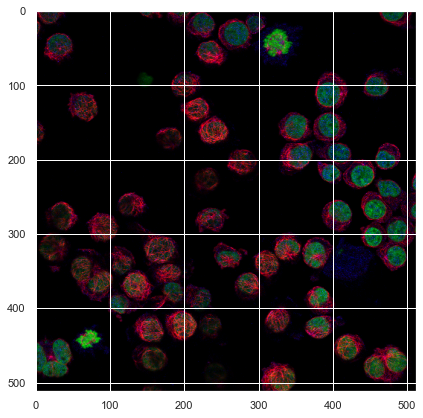

path: b'../data/train/9d1a4e36-bbbe-11e8-b2ba-ac1f6b6435d0.png'
target_id: b'14'
Image shape: (512, 512, 3)


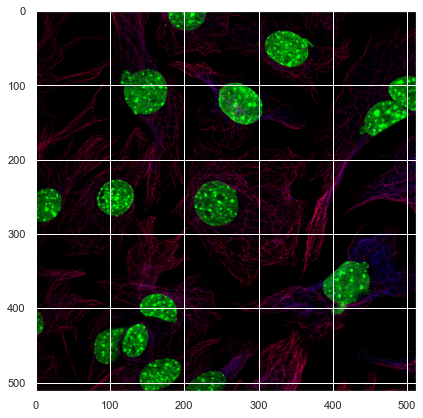

path: b'../data/train/9d1bfacc-bbbb-11e8-b2ba-ac1f6b6435d0.png'
target_id: b'18'
Image shape: (512, 512, 3)


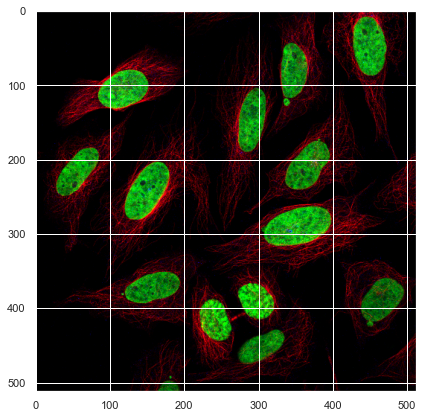

In [8]:
# try opening an image
tfrec_path = '../data/images_train_tfrec/'

raw_dataset = tf.data.TFRecordDataset(f"{tfrec_path}train_images_20of32.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.shuffle(5).take(3):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()